In [1]:
import glob
import json
import keras
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from keras.models import Model, model_from_json
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from librosa.util import lazy
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer


In [2]:
#Codigo para crear mas fuentes de audio ligeramente modificadas a partir de las originales:
import numpy as np
import librosa
import librosa.display
import os
import soundfile as sf

# Ruta al directorio con los archivos de audio
data_dir = 'RawData'
augmented_dir = 'RawData_Aug'

# Crear el directorio de datos aumentados si no existe
os.makedirs(augmented_dir, exist_ok=True)

# Función para cambiar el tono
def pitch_shift(audio, sampling_rate, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sampling_rate, n_steps=n_steps)

# Función para agregar ruido
def add_noise(audio, noise_factor=0.001):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    augmented_audio = augmented_audio.astype(type(audio[0]))
    return augmented_audio

# Función para desplazar en el tiempo
#def time_shift(audio, shift_max, shift_direction):
#    shift = np.random.randint(shift_max)
#    if shift_direction == 'right':
#        shift = -shift
#    augmented_audio = np.roll(audio, shift)
    
# Función para desplazar en el tiempo
def time_shift(audio, shift, shift_direction):
    if shift_direction == 'right':
        shift = -shift
    augmented_audio = np.roll(audio, shift)
    return augmented_audio

# Iterar sobre cada archivo de audio en el directorio
for filename in os.listdir(data_dir):
    if filename.endswith('.wav'):
        # Cargar el archivo de audio
        file_path = os.path.join(data_dir, filename)
        audio, sr = librosa.load(file_path, sr=None)

        # Aplicar cambios de tono a mas
        augmented_audio = pitch_shift(audio, sr, n_steps=2)
        output_path = os.path.join(augmented_dir, f'{os.path.splitext(filename)[0]}_pitch1.wav')
        sf.write(output_path, augmented_audio, sr)

        # Aplicar cambios de tono a menos
        augmented_audio = pitch_shift(audio, sr, n_steps=-2)
        output_path = os.path.join(augmented_dir, f'{os.path.splitext(filename)[0]}_pitch2.wav')
        sf.write(output_path, augmented_audio, sr)

        # Agregar ruido
        augmented_audio = add_noise(audio)
        output_path = os.path.join(augmented_dir, f'{os.path.splitext(filename)[0]}_noise.wav')
        sf.write(output_path, augmented_audio, sr)

        # Cambiar la velocidad a más
        augmented_audio = librosa.effects.time_stretch(audio, rate=1.2)
        output_path = os.path.join(augmented_dir, f'{os.path.splitext(filename)[0]}_stretch1.wav')
        sf.write(output_path, augmented_audio, sr)

        # Cambiar la velocidad a menos
        augmented_audio = librosa.effects.time_stretch(audio, rate=0.8)
        output_path = os.path.join(augmented_dir, f'{os.path.splitext(filename)[0]}_stretch2.wav')
        sf.write(output_path, augmented_audio, sr)

        # Desplazamiento temporal derecha
        SH=int(0.1*len(audio))
        augmented_audio = time_shift(audio, shift=SH, shift_direction='right')
        output_path = os.path.join(augmented_dir, f'{os.path.splitext(filename)[0]}_shift_right.wav')
        sf.write(output_path, augmented_audio, sr)
        
        # Desplazamiento temporal izquierda
        augmented_audio = time_shift(audio, shift=SH, shift_direction='left')
        output_path = os.path.join(augmented_dir, f'{os.path.splitext(filename)[0]}_shift_left.wav')
        sf.write(output_path, augmented_audio, sr)

print("Data augmentation complete.")

Data augmentation complete.


In [3]:
mylist= os.listdir('RawData_Aug/')
mylist

['03-01-01-01-01-01-01_noise.wav',
 '03-01-01-01-01-01-01_pitch1.wav',
 '03-01-01-01-01-01-01_pitch2.wav',
 '03-01-01-01-01-01-01_shift_left.wav',
 '03-01-01-01-01-01-01_shift_right.wav',
 '03-01-01-01-01-01-01_stretch1.wav',
 '03-01-01-01-01-01-01_stretch2.wav',
 '03-01-01-01-01-01-02_noise.wav',
 '03-01-01-01-01-01-02_pitch1.wav',
 '03-01-01-01-01-01-02_pitch2.wav',
 '03-01-01-01-01-01-02_shift_left.wav',
 '03-01-01-01-01-01-02_shift_right.wav',
 '03-01-01-01-01-01-02_stretch1.wav',
 '03-01-01-01-01-01-02_stretch2.wav',
 '03-01-01-01-01-01-03_noise.wav',
 '03-01-01-01-01-01-03_pitch1.wav',
 '03-01-01-01-01-01-03_pitch2.wav',
 '03-01-01-01-01-01-03_shift_left.wav',
 '03-01-01-01-01-01-03_shift_right.wav',
 '03-01-01-01-01-01-03_stretch1.wav',
 '03-01-01-01-01-01-03_stretch2.wav',
 '03-01-01-01-01-01-04_noise.wav',
 '03-01-01-01-01-01-04_pitch1.wav',
 '03-01-01-01-01-01-04_pitch2.wav',
 '03-01-01-01-01-01-04_shift_left.wav',
 '03-01-01-01-01-01-04_shift_right.wav',
 '03-01-01-01-01-01-

In [4]:
print(mylist[4239])
print(mylist[4239][6:8])
print(mylist[4239][18:20])

03-01-04-02-01-02-06_shift_right.wav
04
06


In [5]:
feeling_list=[]
est_animo=[]
# Lista de palabras a seleccionar
selected_emotion = ["neutral", "happy", "sad", "angry", "fear", "disgust", "ps"]

# for item in mylist:

#     #Se extrae el estado de animo del titulo del archivo del dataset TESS:
#     nombre_base, _ = os.path.splitext(item)
#     segundo_guion_posicion = nombre_base.find("_", 4)
#     if segundo_guion_posicion != -1:
#         est_animo = nombre_base[(segundo_guion_posicion+1):len(nombre_base)]
#         # print(est_animo)

for item in mylist:

    #Se extrae el estado de animo del titulo del archivo del dataset TESS:
    nombre_base, _ = os.path.splitext(item)
    primer_guion_posicion = nombre_base.find("_") #codigo nuevo
    # segundo_guion_posicion = nombre_base.find("_", 4)
    segundo_guion_posicion = nombre_base.find("_", primer_guion_posicion + 1) #codigo nuevo
    # Encuentra la tercera ocurrencia de '_' //codigo nuevo
    tercer_guion_posicion = nombre_base.find("_", segundo_guion_posicion + 1) #codigo nuevo
    # if segundo_guion_posicion != -1:
    if tercer_guion_posicion != -1: #codigo nuevo
    #   est_animo = nombre_base[(segundo_guion_posicion+1):len(nombre_base)]
        est_animo = nombre_base[(segundo_guion_posicion + 1):tercer_guion_posicion] #codigo nuevo
        # print(est_animo)


    #Se asigna los estados de animo del Dataset TESS:
    if est_animo == selected_emotion[0]:
        feeling_list.append('female_neutral')
    elif est_animo == selected_emotion[1]:
        feeling_list.append('female_happy')
    elif est_animo == selected_emotion[2]:
        feeling_list.append('female_sad')
    elif est_animo == selected_emotion[3]:
        feeling_list.append('female_angry')
    elif est_animo == selected_emotion[4]:
        feeling_list.append('female_fearful')
    elif est_animo == selected_emotion[5]:
        feeling_list.append('female_disgust')
    elif est_animo == selected_emotion[6]:
        feeling_list.append('female_surprised')

    #Se asigna los estados de animo del Dataset RAVNESS:
    if item[6:8]=='01' and int(item[18:20])%2==0:
        feeling_list.append('female_neutral')
    elif item[6:8]=='01' and int(item[18:20])%2==1:
        feeling_list.append('male_neutral')
    elif item[6:8]=='02' and int(item[18:20])%2==0:
        feeling_list.append('female_neutral') #Se integra "neutral" con "calm"
    elif item[6:8]=='02' and int(item[18:20])%2==1:
        feeling_list.append('male_neutral') #Se integra "neutral" con "calm"
    elif item[6:8]=='03' and int(item[18:20])%2==0:
        feeling_list.append('female_happy')
    elif item[6:8]=='03' and int(item[18:20])%2==1:
        feeling_list.append('male_happy')
    elif item[6:8]=='04' and int(item[18:20])%2==0:
        feeling_list.append('female_sad')
    elif item[6:8]=='04' and int(item[18:20])%2==1:
        feeling_list.append('male_sad')
    elif item[6:8]=='05' and int(item[18:20])%2==0:
        feeling_list.append('female_angry')
    elif item[6:8]=='05' and int(item[18:20])%2==1:
        feeling_list.append('male_angry')
    elif item[6:8]=='06' and int(item[18:20])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:8]=='06' and int(item[18:20])%2==1:
        feeling_list.append('male_fearful')
    elif item[6:8]=='07' and int(item[18:20])%2==0:
        feeling_list.append('female_disgust')
    elif item[6:8]=='07' and int(item[18:20])%2==1:
        feeling_list.append('male_disgust')
    elif item[6:8]=='08' and int(item[18:20])%2==0:
        feeling_list.append('female_surprised')
    elif item[6:8]=='08' and int(item[18:20])%2==1:
        feeling_list.append('male_surprised')

In [6]:
feeling_list

['male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'male_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_neutral',
 'female_ne

In [7]:
labels = pd.DataFrame(feeling_list)
labelss=labels.rename(columns={0: 'Emotions'}) #Se renombra el título de la columna
labelss[:29680]

,Emotions
0,male_neutral
1,male_neutral
2,male_neutral
3,male_neutral
4,male_neutral
...,...
29675,female_sad
29676,female_sad
29677,female_sad
29678,female_sad


## Obtención de las características de los archivos de audio con Librosa

In [8]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    X, sample_rate = librosa.load('RawData_Aug/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)   #El número de coeficientes mfcc está relacionado con la frecuencia de muestreo de la señal de audio. Se recomienda extraer un número de coeficientes mfcc igual a un cuarto de la frecuencia de muestreo dividida por 13.29. En nuestro caso, hemos cogido 13 coeficientes MFCC al tratarse de una práctica común y ampliamente utilizada, basada en estudios que sugieren que este número captura adecuadamente la información perceptivamente relevante del espectro de audio para tareas como el reconocimiento de voz y la clasificación de emociones.
    feature = mfccs
    df.loc[bookmark] = [feature]
    bookmark=bookmark+1        

In [64]:
#Se muestran los resultados agrupados en la columna "feature":
df[:29680]

,feature
0,"[-42.579998, -42.40106, -42.63471, -41.658806,..."
1,"[-63.03742, -65.00583, -66.66983, -67.28745, -..."
2,"[-63.6462, -65.425, -66.405075, -66.33299, -66..."
3,"[-65.92159, -65.92159, -65.92159, -65.92159, -..."
4,"[-61.614525, -57.218075, -53.91826, -55.53662,..."
...,...
29675,"[-14.182665, -17.613264, -26.834442, -28.91544..."
29676,"[-36.54438, -34.601017, -36.04222, -31.059767,..."
29677,"[-20.612898, -19.055407, -19.209393, -18.69526..."
29678,"[-16.877892, -21.438084, -30.812662, -29.86657..."


In [65]:
#Se crea la copia "df2" del DataFrame de pandas (df) separando individualmente los resultados de la columna "feature":
df2 = pd.DataFrame(df['feature'].values.tolist())
df2[:29680]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-42.579998,-42.401058,-42.634708,-41.658806,-40.756615,-42.452438,-41.612186,-38.970215,-39.890053,-39.281651,...,-41.576973,-40.616489,-42.433720,-41.344578,-40.626751,-40.155827,-39.448544,-42.672073,-40.714092,-41.788750
1,-63.037418,-65.005829,-66.669830,-67.287453,-68.558067,-67.600204,-64.373993,-65.265434,-66.569328,-66.525711,...,-61.719597,-61.664814,-65.102875,-64.612320,-63.308891,-63.294292,-63.697121,-61.154915,-60.509026,-61.649410
2,-63.646198,-65.425003,-66.405075,-66.332993,-66.921745,-65.886627,-65.463516,-66.057571,-64.519768,-65.093704,...,-60.843559,-62.265034,-64.428879,-65.732025,-64.407623,-64.002449,-62.538998,-62.779709,-63.208103,-60.739964
3,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,...,-56.516617,-60.150635,-61.763290,-60.687485,-56.944359,-56.765747,-60.142361,-61.449783,-63.798618,-63.813591
4,-61.614525,-57.218075,-53.918259,-55.536621,-56.447006,-55.554886,-55.437729,-56.230534,-56.135986,-56.615444,...,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29675,-14.182665,-17.613264,-26.834442,-28.915443,-28.501810,-27.867954,-27.804068,-29.921848,-29.119289,-27.622171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29676,-36.544380,-34.601017,-36.042221,-31.059767,-23.514446,-19.393410,-18.620173,-18.691460,-18.765795,-18.849939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29677,-20.612898,-19.055407,-19.209393,-18.695263,-16.728975,-15.619523,-17.330921,-19.615959,-20.122488,-24.445810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29678,-16.877892,-21.438084,-30.812662,-29.866575,-28.868805,-26.216677,-23.669178,-23.294621,-23.804501,-24.265003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
#Se crea un nuevo dataframe "Newdf" y se concatena el "df2" y el "labels":
newdf = pd.concat([df2,labelss], axis=1)
newdf[:29680]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,Emotions
0,-42.579998,-42.401058,-42.634708,-41.658806,-40.756615,-42.452438,-41.612186,-38.970215,-39.890053,-39.281651,...,-40.616489,-42.433720,-41.344578,-40.626751,-40.155827,-39.448544,-42.672073,-40.714092,-41.788750,male_neutral
1,-63.037418,-65.005829,-66.669830,-67.287453,-68.558067,-67.600204,-64.373993,-65.265434,-66.569328,-66.525711,...,-61.664814,-65.102875,-64.612320,-63.308891,-63.294292,-63.697121,-61.154915,-60.509026,-61.649410,male_neutral
2,-63.646198,-65.425003,-66.405075,-66.332993,-66.921745,-65.886627,-65.463516,-66.057571,-64.519768,-65.093704,...,-62.265034,-64.428879,-65.732025,-64.407623,-64.002449,-62.538998,-62.779709,-63.208103,-60.739964,male_neutral
3,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,-65.921593,...,-60.150635,-61.763290,-60.687485,-56.944359,-56.765747,-60.142361,-61.449783,-63.798618,-63.813591,male_neutral
4,-61.614525,-57.218075,-53.918259,-55.536621,-56.447006,-55.554886,-55.437729,-56.230534,-56.135986,-56.615444,...,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,-65.984756,male_neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29675,-14.182665,-17.613264,-26.834442,-28.915443,-28.501810,-27.867954,-27.804068,-29.921848,-29.119289,-27.622171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_sad
29676,-36.544380,-34.601017,-36.042221,-31.059767,-23.514446,-19.393410,-18.620173,-18.691460,-18.765795,-18.849939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_sad
29677,-20.612898,-19.055407,-19.209393,-18.695263,-16.728975,-15.619523,-17.330921,-19.615959,-20.122488,-24.445810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_sad
29678,-16.877892,-21.438084,-30.812662,-29.866575,-28.868805,-26.216677,-23.669178,-23.294621,-23.804501,-24.265003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_sad


In [88]:
#Se realiza una mezcla de todas las muestras aleatoriamente:
rnewdf = shuffle(newdf)
rnewdf[:29680]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,Emotions
24520,-16.411951,-19.116829,-28.031155,-27.195835,-27.127241,-27.576952,-26.551523,-25.633757,-26.603895,-25.137882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_neutral
20559,-16.377066,-18.169479,-22.099112,-27.042805,-31.882229,-33.745686,-31.700460,-31.396297,-28.736111,-25.150572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_sad
18754,-24.331573,-27.110615,-35.281734,-34.395992,-31.884712,-32.053989,-34.160107,-34.139870,-34.814579,-36.033321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_angry
29527,-27.163368,-28.325182,-31.084551,-31.556446,-31.624052,-30.453524,-30.214128,-30.847429,-29.933256,-30.639559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_sad
12118,-26.203215,-28.019428,-32.759373,-33.591320,-33.043633,-32.256271,-32.055485,-31.193621,-31.903032,-33.234241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15950,-17.551826,-18.759905,-23.453548,-24.512520,-23.579237,-22.154610,-23.014402,-24.559498,-24.896383,-25.369307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_surprised
16075,-13.202082,-17.642233,-30.207256,-30.159901,-30.258949,-32.175896,-32.549263,-30.332821,-29.921741,-28.735159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_fearful
5967,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,...,-30.646793,-27.645739,-28.799168,-28.166622,-27.124346,-22.878021,-19.233665,-21.655403,-28.529062,male_angry
9370,-62.494873,-65.332138,-69.713181,-69.713181,-69.713181,-69.713181,-69.659279,-66.693207,-63.192284,-59.579689,...,-57.374203,-60.116817,-60.202209,-58.259033,-59.252151,-60.162540,-58.262691,-56.665581,-58.837490,male_surprised


In [89]:
#Se rellenan todos los valores nulos (NaN) del DataFrame "rnewdf" con el valor 0:
rnewdf=rnewdf.fillna(0)
rnewdf

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,Emotions
24520,-16.411951,-19.116829,-28.031155,-27.195835,-27.127241,-27.576952,-26.551523,-25.633757,-26.603895,-25.137882,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_neutral
20559,-16.377066,-18.169479,-22.099112,-27.042805,-31.882229,-33.745686,-31.700460,-31.396297,-28.736111,-25.150572,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_sad
18754,-24.331573,-27.110615,-35.281734,-34.395992,-31.884712,-32.053989,-34.160107,-34.139870,-34.814579,-36.033321,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_angry
29527,-27.163368,-28.325182,-31.084551,-31.556446,-31.624052,-30.453524,-30.214128,-30.847429,-29.933256,-30.639559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_sad
12118,-26.203215,-28.019428,-32.759373,-33.591320,-33.043633,-32.256271,-32.055485,-31.193621,-31.903032,-33.234241,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15950,-17.551826,-18.759905,-23.453548,-24.512520,-23.579237,-22.154610,-23.014402,-24.559498,-24.896383,-25.369307,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_surprised
16075,-13.202082,-17.642233,-30.207256,-30.159901,-30.258949,-32.175896,-32.549263,-30.332821,-29.921741,-28.735159,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_fearful
5967,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,...,-30.646793,-27.645739,-28.799168,-28.166622,-27.124346,-22.878021,-19.233665,-21.655403,-28.529062,male_angry
9370,-62.494873,-65.332138,-69.713181,-69.713181,-69.713181,-69.713181,-69.659279,-66.693207,-63.192284,-59.579689,...,-57.374203,-60.116817,-60.202209,-58.259033,-59.252151,-60.162540,-58.262691,-56.665581,-58.837490,male_surprised


## División de los datos para test y train

In [90]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [91]:
train[0:23804]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,Emotions
24520,-16.411951,-19.116829,-28.031155,-27.195835,-27.127241,-27.576952,-26.551523,-25.633757,-26.603895,-25.137882,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_neutral
20559,-16.377066,-18.169479,-22.099112,-27.042805,-31.882229,-33.745686,-31.700460,-31.396297,-28.736111,-25.150572,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_sad
18754,-24.331573,-27.110615,-35.281734,-34.395992,-31.884712,-32.053989,-34.160107,-34.139870,-34.814579,-36.033321,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_angry
29527,-27.163368,-28.325182,-31.084551,-31.556446,-31.624052,-30.453524,-30.214128,-30.847429,-29.933256,-30.639559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_sad
12118,-26.203215,-28.019428,-32.759373,-33.591320,-33.043633,-32.256271,-32.055485,-31.193621,-31.903032,-33.234241,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15950,-17.551826,-18.759905,-23.453548,-24.512520,-23.579237,-22.154610,-23.014402,-24.559498,-24.896383,-25.369307,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_surprised
16075,-13.202082,-17.642233,-30.207256,-30.159901,-30.258949,-32.175896,-32.549263,-30.332821,-29.921741,-28.735159,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_fearful
5967,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,...,-30.646793,-27.645739,-28.799168,-28.166622,-27.124346,-22.878021,-19.233665,-21.655403,-28.529062,male_angry
9370,-62.494873,-65.332138,-69.713181,-69.713181,-69.713181,-69.713181,-69.659279,-66.693207,-63.192284,-59.579689,...,-57.374203,-60.116817,-60.202209,-58.259033,-59.252151,-60.162540,-58.262691,-56.665581,-58.837490,male_surprised


In [92]:
#Se retira la columna "Emotions" para entrenar los datos métricos independientemente:
trainfeatures = train.iloc[:, :-1]
trainfeatures[:23804]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
24520,-16.411951,-19.116829,-28.031155,-27.195835,-27.127241,-27.576952,-26.551523,-25.633757,-26.603895,-25.137882,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20559,-16.377066,-18.169479,-22.099112,-27.042805,-31.882229,-33.745686,-31.700460,-31.396297,-28.736111,-25.150572,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18754,-24.331573,-27.110615,-35.281734,-34.395992,-31.884712,-32.053989,-34.160107,-34.139870,-34.814579,-36.033321,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
29527,-27.163368,-28.325182,-31.084551,-31.556446,-31.624052,-30.453524,-30.214128,-30.847429,-29.933256,-30.639559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12118,-26.203215,-28.019428,-32.759373,-33.591320,-33.043633,-32.256271,-32.055485,-31.193621,-31.903032,-33.234241,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15950,-17.551826,-18.759905,-23.453548,-24.512520,-23.579237,-22.154610,-23.014402,-24.559498,-24.896383,-25.369307,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16075,-13.202082,-17.642233,-30.207256,-30.159901,-30.258949,-32.175896,-32.549263,-30.332821,-29.921741,-28.735159,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5967,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,-38.679691,...,-30.928692,-30.646793,-27.645739,-28.799168,-28.166622,-27.124346,-22.878021,-19.233665,-21.655403,-28.529062
9370,-62.494873,-65.332138,-69.713181,-69.713181,-69.713181,-69.713181,-69.659279,-66.693207,-63.192284,-59.579689,...,-56.442131,-57.374203,-60.116817,-60.202209,-58.259033,-59.252151,-60.162540,-58.262691,-56.665581,-58.837490


In [93]:
#Se separa la columna "Emotions" respectivamente:
trainlabel = train.iloc[:, -1:]
trainlabel[:23804]

,Emotions
24520,female_neutral
20559,female_sad
18754,female_angry
29527,female_sad
12118,female_neutral
...,...
15950,female_surprised
16075,female_fearful
5967,male_angry
9370,male_surprised


In [94]:
#Se retira la columna "Emotions" para testear los datos métricos independientemente:
testfeatures = test.iloc[:, :-1]
testfeatures[:5876]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
11353,-32.278847,-31.038212,-30.057852,-31.106361,-32.056831,-32.648155,-33.318432,-33.535328,-33.211380,-33.567326,...,-19.799997,-19.680218,-19.471479,-17.847542,-17.750099,-19.108231,-21.121490,-18.144770,-19.312809,-23.176056
11560,-29.502359,-26.698360,-27.915680,-27.179207,-23.408674,-15.322147,-14.682059,-16.942106,-20.528883,-21.470936,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3190,-59.379234,-56.715298,-55.581871,-54.006161,-55.326309,-56.387470,-55.373562,-55.056889,-54.322975,-53.788284,...,-58.100754,-58.241211,-58.005173,-58.161888,-58.175434,-58.245380,-58.169331,-58.132809,-58.220261,-58.108589
3740,-63.678261,-65.519722,-68.038109,-68.940498,-68.680038,-66.777290,-65.900421,-64.412834,-66.014778,-65.932915,...,-51.143311,-50.431767,-51.595406,-50.232361,-51.723759,-52.557041,-50.826725,-50.555283,-53.217522,-55.987209
3984,-62.309334,-64.163918,-64.846329,-64.792992,-64.817886,-64.831223,-64.848671,-64.701591,-64.793564,-64.359352,...,-57.157780,-57.370930,-59.771935,-59.867119,-60.586609,-61.340591,-62.275906,-62.124084,-61.474556,-61.143398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19882,-20.325174,-21.911461,-26.770912,-26.880039,-27.298449,-28.805305,-28.835733,-27.055288,-27.355394,-26.752920,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21423,-13.232435,-18.184322,-31.162931,-30.990753,-30.680157,-31.863995,-31.496166,-32.610367,-33.688278,-32.240547,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25510,-21.016701,-24.620790,-30.300270,-27.958160,-28.085400,-28.047678,-28.041433,-27.498676,-25.904726,-27.575533,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4929,-63.427303,-63.291176,-63.123089,-66.918549,-67.395393,-67.395393,-67.395393,-67.395393,-67.395393,-67.395393,...,-50.206619,-50.588913,-51.267067,-51.096684,-50.855949,-49.809875,-49.322372,-49.508469,-50.587925,-52.469891


In [95]:
#Se separa la columna "Emotions" respectivamente:
testlabel = test.iloc[:, -1:]
testlabel[:5876]

,Emotions
11353,female_sad
11560,female_disgust
3190,female_happy
3740,male_sad
3984,female_sad
...,...
19882,female_angry
21423,female_happy
25510,female_sad
4929,male_angry


In [96]:
#Se convierte a arrays de NumPy:
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

#Se codifican las etiquetas:
lb = LabelEncoder()

#Se transforman y categorizan las etiquetas:
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

c:\Users\diego\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\diego\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [97]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [98]:
X_train.shape

(23615, 216)

## Redimensión del Modelo CNN:

In [99]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Se define el modelo: #test 22062024 - 2
model = Sequential()

# Primera capa convolucional
model.add(Conv1D(256, 5, padding='same', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Segunda capa convolucional
model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=4))  # pool_size reducido para retener más información

# Tercera capa convolucional
model.add(Conv1D(256, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Cuarta capa convolucional
model.add(Conv1D(256, 7, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=4))  # pool_size reducido para retener más información

# Quinta capa convolucional
model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Sexta capa convolucional
model.add(Conv1D(256, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Séptima capa convolucional
model.add(Conv1D(256, 7, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Octava capa convolucional
model.add(Conv1D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))  # pool_size reducido para retener más información



model.add(Conv1D(128, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(512))  # Aumentar la cantidad de neuronas
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(14))  # Asegurar que coincide con el número de clases
model.add(Activation('softmax'))

# model.add(Conv1D(256, 5, padding='same', input_shape=(216, 1))) #original
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=8))
# model.add(Conv1D(128, 5, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(128))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(Dense(14))  # Asegúrate de que coincide con el número de clases
# model.add(Activation('softmax'))

# Definir el optimizador correctamente
#opt = RMSprop(learning_rate=0.00001, decay=1e-6) #test 22062024 - normal formula used
#opt = Adam(learning_rate=0.001) #test 22062024 - 2
opt = Adam(learning_rate=0.001) #tasa de aprendizaje

c:\Users\diego\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 216, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 216, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 216, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 216, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 54, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 54, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 54, 256)        │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 54, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 54, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 13, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 13, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 13, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 13, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 13, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 13, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 13, 256)        │             

 Total params: 2,741,646 (10.46 MB)

 Trainable params: 2,736,270 (10.44 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [102]:
# Se configura el modelo para el proceso train:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [103]:
# Early Stopping:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True) #metricas sobre 'val_loss'. Interesa minimizar este valor al máximo!

### Eliminación de la parte Train para evitar innecesarias listas de Epochs

Epoch 1/1000
738/738 ━━━━━━━━━━━━━━━━━━━━ 60s 77ms/step - accuracy: 0.2982 - loss: 2.1510 - val_accuracy: 0.1444 - val_loss: 3.6329
Epoch 2/1000
738/738 ━━━━━━━━━━━━━━━━━━━━ 65s 89ms/step - accuracy: 0.5608 - loss: 1.2629 - val_accuracy: 0.4368 - val_loss: 1.8898
Epoch 3/1000
738/738 ━━━━━━━━━━━━━━━━━━━━ 61s 83ms/step - accuracy: 0.6319 - loss: 1.0551 - val_accuracy: 0.5622 - val_loss: 1.2246
Epoch 4/1000
738/738 ━━━━━━━━━━━━━━━━━━━━ 60s 81ms/step - accuracy: 0.6679 - loss: 0.9551 - val_accuracy: 0.6333 - val_loss: 1.0917
Epoch 5/1000
738/738 ━━━━━━━━━━━━━━━━━━━━ 61s 82ms/step - accuracy: 0.6828 - loss: 0.9174 - val_accuracy: 0.6112 - val_loss: 1.1034
Epoch 6/1000
738/738 ━━━━━━━━━━━━━━━━━━━━ 62s 84ms/step - accuracy: 0.7048 - loss: 0.8510 - val_accuracy: 0.5484 - val_loss: 1.2656
Epoch 7/1000
738/738 ━━━━━━━━━━━━━━━━━━━━ 60s 81ms/step - accuracy: 0.7231 - loss: 0.8051 - val_accuracy: 0.5273 - val_loss: 1.4670
Epoch 8/1000
738/738 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.7383 -

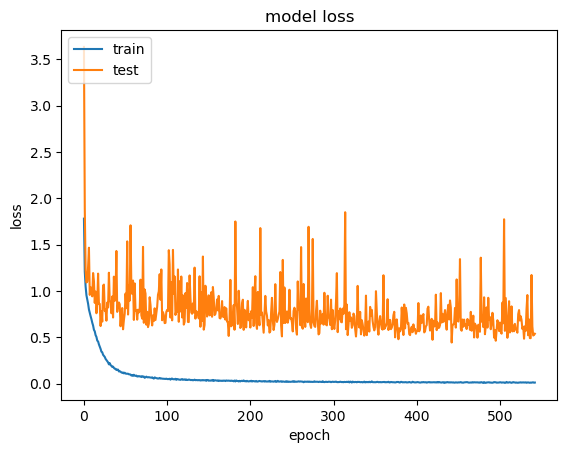

In [104]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size=32, epochs=1000, validation_data=(x_testcnn, y_test), callbacks=[early_stopping]) #test 22062024 - 2 #incorporado el "earlystopping" para que pare cuando varia poquito.
#cnnhistory = model.fit(x_traincnn, y_train, batch_size=32, epochs=500, validation_data=(x_testcnn, y_test))

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Saving the model

In [105]:
#Se guarda el modelo y valores entrenados en el archivo "Emotion_Voice_Detection_Model.h5":
model_name = 'Emotion_Voice_Detection_Model_test2.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\Users\diego\Desktop\testnotebook\proyecto3\Proyecto-3\saved_models\Emotion_Voice_Detection_Model_test2.h5 


In [106]:
#Se guarda la arquitectura del modelo en el archivo "model.json":
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Se carga el modelo obtenido

In [107]:
# Se carga y crea el modelo desde el archivo "model.json":
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Se cargan las métricas en el modelo:
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model_test2.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
compile_metrics: 88.06%


## Proceso de predicción de emociones mediante los datos de Test

In [108]:
#Se realizan predicciones sobre el conjunto de datos:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step


In [109]:
preds

array([[1.45713441e-09, 1.75595487e-12, 1.57116486e-10, ...,
        5.08547612e-15, 5.24297741e-14, 6.12721392e-23],
       [1.23486048e-08, 9.99999762e-01, 9.83372317e-08, ...,
        2.12440319e-14, 1.10737569e-12, 8.17510122e-15],
       [1.70513928e-01, 1.41280606e-01, 1.22186458e-02, ...,
        2.32437196e-06, 8.88168051e-06, 7.50015261e-06],
       ...,
       [3.46941226e-10, 1.23906345e-11, 2.56455365e-07, ...,
        1.42401698e-11, 7.87096191e-13, 1.51287592e-13],
       [1.09859123e-07, 1.17244312e-08, 9.99997973e-01, ...,
        1.69504397e-10, 7.24047124e-12, 6.15011988e-14],
       [7.16754175e-06, 5.69373915e-05, 4.47961327e-04, ...,
        1.32686990e-08, 2.57540160e-05, 8.91873424e-05]], dtype=float32)

In [110]:
#Se determina la clase con la mayor probabilidad para cada muestra:
preds1=preds.argmax(axis=1)

In [111]:
preds1

array([5, 1, 3, ..., 6, 2, 9], dtype=int64)

In [112]:
#Se asegura que todos los elementos de "preds1" sean de tipo entero y se reconvierte en un arreglo unidimensional:
abc = preds1.astype(int).flatten()

In [113]:
#Se reconvierten los índices de clases predichos "abc" a las etiquetas originales:
predictions = (lb.inverse_transform((abc)))

In [114]:
#Se crea un DataFrame con las predicciones del modelo:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:827]

,predictedvalues
0,female_sad
1,female_disgust
2,female_happy
3,male_neutral
4,female_sad
...,...
822,male_sad
823,female_fearful
824,female_happy
825,male_fearful


In [115]:
#Se toman las etiquetas reales del conjunto de datos de prueba, se convierten en sus valores originales y se almacenan:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [116]:
#Se crea un DataFrame que contiene las etiquetas reales del conjunto de datos de test:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:827]

,actualvalues
0,female_sad
1,female_disgust
2,female_happy
3,male_sad
4,female_sad
...,...
822,male_sad
823,female_fearful
824,female_happy
825,male_fearful


In [117]:
#Se combinan los dos dataframes:
finaldf = actualdf.join(preddf)

## Comparativa de los valores Actual vs Predictivo de las emociones

In [118]:
finaldf[:827]

,actualvalues,predictedvalues
0,female_sad,female_sad
1,female_disgust,female_disgust
2,female_happy,female_happy
3,male_sad,male_neutral
4,female_sad,female_sad
...,...,...
822,male_sad,male_sad
823,female_fearful,female_fearful
824,female_happy,female_happy
825,male_fearful,male_fearful


In [119]:
#Se agrupa y muestra cuántas veces aparece cada valor único real:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,722
female_disgust,717
female_fearful,680
female_happy,715
female_neutral,788
female_sad,727
female_surprised,703
male_angry,154
male_disgust,137


In [120]:
#Se agrupa y muestra cuántas veces aparece cada valor único predicho:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,696
female_disgust,682
female_fearful,700
female_happy,737
female_neutral,842
female_sad,755
female_surprised,689
male_angry,130
male_disgust,139


In [121]:
#Se guarda el dataframe comparativo en el archivo "predictions.csv":
finaldf.to_csv('Predictions.csv', index=False)